# 1. Problem Definition

- How can we develop a predictive model that effectively identifies individuals at risk of experiencing a stroke by analyzing a dataset containing demographic, lifestyle, and health-related factors?
- Which machine learning model would best predict the likelihood of stroke occurrence in individuals?

# 2. Features of Dataset

1. **Gender**: (0: 'Female', 1: 'Male')
2. **Age**: Patient's age in years.
3. **Hypertension**: (0 : No history of hypertension, 1: History of hypertension)
4. **Heart Disease**: (0: No history of heart disease, 1: History of heart disease)
5. **Ever Married**: (0: Patient has not been married before, 1: Patient has been married before)
6. **Work Type**: (0: 'Govt_job', 1: 'Never_worked', 2: 'Private', 3: 'Self-employed', 4: 'children')
7. **Residence Type**: (0: 'Rural', 1: 'Urban')
8. **Average Glucose Level**: Numeric data representing the average patient's glucose level.
9. **BMI**: Numeric data representing Body Mass Index.
10. **Smoking Status**: (0: 'Unknown', 1: 'formerly smoked', 2: 'never smoked', 3: 'smokes')

Before data cleaning, there were 5110 rows of data. However, there were "NaN" values under "BMI" and an anomaly of "Other" under "Gender". Hence, after data cleaning, we are left with 4908 rows of data.

# 3. Libraries and Packages

For this project, we will utilize Python along with the following libraries for data analysis, machine learning, and data visualization. Below are the main libraries we will be using:

- **Pandas**: Used for data manipulation and analysis.
- **Matplotlib** and **Seaborn**: Employed for data visualization tasks.
- **Scikit-learn**: Utilized for various machine learning tasks such as data preprocessing, model training, and evaluation.
- **Imbalanced-learn**: Employed for addressing class imbalance issues within the dataset.


In [1]:
# Importing necessary packages for data manipulation and analysis
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

# Importing models and tools from Scikit-Learn for machine learning
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_squared_error, roc_curve, auc
from sklearn.model_selection import cross_val_score, train_test_split, learning_curve
import xgboost as xgb

# Importing packages for handling imbalanced data
import imblearn
from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

# Ignoring warnings
import warnings
warnings.filterwarnings('ignore')

## 3.1 Import Cleaned Dataset

In [2]:
# Import the data set
traindata = pd.read_csv('cleaned_data.csv')
traindata.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67.0,0,1,1,2,1,228.69,36.6,1,1
1,1,80.0,0,1,1,2,0,105.92,32.5,2,1
2,0,49.0,0,0,1,2,1,171.23,34.4,3,1
3,0,79.0,1,0,1,3,0,174.12,24.0,2,1
4,1,81.0,0,0,1,2,1,186.21,29.0,1,1


# 4. Addressing the Imbalanced Dataset

## 4.1 The Metric Trap

One of the challenge when handling unbalanced datasets is the choice of evaluation metrics for our models. Replying on simpler metrics such as `accuracy_score` can lead to misleading conclusions. In datasets where class imbalances are prominent, a classifier might achieve a seemingly high accuracy rate by consistently predicting the most frequent class without performing any analysis of the features. This will produce a high accuracy rate. However, the high accuracy is inherently deceptive.

To prove that the metric trap exists, we will conduct a simple experiment without feature engineering.

In [3]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Remove 'id', 'work_type', 'Residence_type', 'stroke' columns
labels = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'smoking_status', 'age', 
          'avg_glucose_level', 'bmi']

X = traindata[labels]
y = traindata['stroke']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,)

model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy score: %.2f%%" % (accuracy * 100.0))

Accuracy score: 95.93%


Modify the code to use only one feature which should drastically reduce the accuracy score of the classifier.

In [4]:
# Using only one feature
model = XGBClassifier()
model.fit(X_train[['gender']], y_train)
y_pred = model.predict(X_test[['gender']])

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy score: %.2f%%" % (accuracy * 100.0))

Accuracy score: 96.84%


As observed, the accuracy rate did not change drastically as mentioned above. There was only a slight difference in the accuracy score. This minute variance emphasizes the significance of selecting appropriate evaluation metrics for unbalanced datasets.

# 5. Data Modeling

## 5.1 Separate Predictors and Responses

In [5]:
# Splitting the data into input data features and target
columns_to_drop = ['stroke', 'work_type', 'Residence_type']
predictors = traindata.drop(columns=columns_to_drop)
stroke = traindata['stroke']

In [6]:
predictors.head()

,gender,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,smoking_status
0,1,67.0,0,1,1,228.69,36.6,1
1,1,80.0,0,1,1,105.92,32.5,2
2,0,49.0,0,0,1,171.23,34.4,3
3,0,79.0,1,0,1,174.12,24.0,2
4,1,81.0,0,0,1,186.21,29.0,1


Based on domain knowledge, `work_type` and `Residence_type` lack significant contributions to predicting strokes. Hence, we decided to remove these features from our dataset.

## 5.2 Split the Dataset into Training and Testing Datasets in 8:2 Ratio

In [7]:
# Split the Dataset into Train and Test
predictors_train, predictors_test, stroke_train, stroke_test = train_test_split(predictors, stroke, test_size=0.2, random_state=42)

In [8]:
print("Number transactions x_train dataset: ", stroke_train.shape)
print("Number transactions y_train dataset: ", predictors_train.shape)
print("Number transactions x_test dataset: ", stroke_test.shape)
print("Number transactions y_test dataset: ", predictors_test.shape)

Number transactions x_train dataset:  (3926,)
Number transactions y_train dataset:  (3926, 8)
Number transactions x_test dataset:  (982,)
Number transactions y_test dataset:  (982, 8)


## 5.3 SMOTE-Tomek Resampling

In our stroke prediction dataset, class imbalance poses a significant challenge, with notably fewer instances of patients with strokes compared to those without. To tackle this issue, we employ SMOTE-Tomek, a hybrid resampling technique that combines SMOTE oversampling and Tomek links undersampling. SMOTE-Tomek generates synthetic samples for the minority class while removing Tomek links, effectively balancing the dataset and reducing noise. By providing a more representative training set, SMOTE-Tomek enhances the model's ability to detect stroke-related patterns, mitigates overfitting risks, and improves generalization. Ultimately, this approach leads to more reliable predictions and enhances the model's utility in real-world healthcare scenarios.

In [9]:
# Define and initialize SMOTE-Tomek resampler
smote_tomek = SMOTETomek(random_state=42)

# Resample the training data using SMOTE-Tomek
X_train_st, y_train_st = smote_tomek.fit_resample(predictors_train, stroke_train)

# Print class distribution before and after SMOTE-Tomek
print("Before SMOTETomek:")
print("Class distribution in stroke_train:", Counter(stroke_train))
print()

# Print class distribution after SMOTE-Tomek
print("After SMOTETomek:")
print("Class distribution in y_train_st (SMOTETomek):", Counter(y_train_st))

Before SMOTETomek:
Class distribution in stroke_train: Counter({0: 3770, 1: 156})

After SMOTETomek:
Class distribution in y_train_st (SMOTETomek): Counter({0: 3735, 1: 3735})


In [10]:
predictors_categorical_factors = X_train_st[['gender', 'hypertension', 'heart_disease', 'ever_married', 'smoking_status']]

predictors_numerical_factors = X_train_st[['age','avg_glucose_level', 'bmi']]

## 5.4 Feature Importance

### 5.4.1 Feature Importance for Numerical Features Using Pearson Correlation

Pearson correlation results for 'age':
Pearson correlation coefficient: 0.6069236307959848
p-value: 0.0

Pearson correlation results for 'avg_glucose_level':
Pearson correlation coefficient: 0.3072008768912436
p-value: 5.3379512149962095e-163

Pearson correlation results for 'bmi':
Pearson correlation coefficient: 0.10162823797891923
p-value: 1.3087857837236026e-18



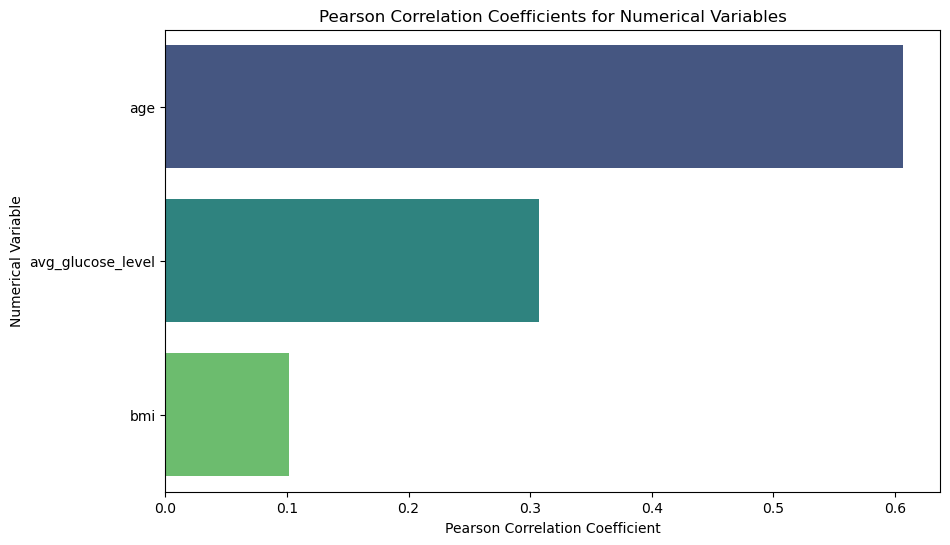

In [11]:
from scipy.stats import chi2_contingency, pearsonr

# Assuming you have numerical predictors stored in a DataFrame called numerical_factors

# Store Pearson correlation results in a DataFrame
pearson_results = []

# Perform Pearson correlation for each numerical feature
for col in predictors_numerical_factors.columns:
    pearson_corr, p_value = pearsonr(predictors_numerical_factors[col], y_train_st)
    print(f"Pearson correlation results for '{col}':")
    print('Pearson correlation coefficient:', pearson_corr)
    print('p-value:', p_value)
    print()
    
    pearson_results.append({'Numerical Variable': col, 'Pearson Correlation Coefficient': pearson_corr, 'p-value': p_value})

# Convert results to DataFrame
pearson_results_df = pd.DataFrame(pearson_results)

# Sort DataFrame by absolute value of Pearson correlation coefficient
pearson_results_df_sorted = pearson_results_df.reindex(pearson_results_df['Pearson Correlation Coefficient'].abs().sort_values(ascending=False).index)

# Plot the bar plot
plt.figure(figsize=(10, 6))
sb.barplot(data=pearson_results_df_sorted, x='Pearson Correlation Coefficient', y='Numerical Variable', palette='viridis')
plt.title('Pearson Correlation Coefficients for Numerical Variables')
plt.xlabel('Pearson Correlation Coefficient')
plt.ylabel('Numerical Variable')
plt.show()


Pearson correlation is a statistical method used to measure the strength and direction of the linear relationship between two continuous variables. It produces a correlation coefficient that ranges from -1 to +1, where +1 indicates a perfect positive linear relationship, -1 indicates a perfect negative linear relationship, and 0 indicates no linear relationship.

- **Age**:
The Pearson correlation coefficient of 0.6069 indicates a strong positive correlation between age and stroke occurrence. This suggests that as age increases, the likelihood of experiencing a stroke also increases. The p-value of 0.0 indicates that this correlation is statistically significant, meaning it is highly unlikely to occur by random chance.

- **Average Glucose Level**:
The Pearson correlation coefficient of 0.3072 suggests a moderate positive correlation between average glucose level and stroke occurrence. This indicates that higher average glucose levels are associated with a higher likelihood of experiencing a stroke. The very low p-value (5.338e-163) indicates that this correlation is statistically significant.

- **BMI (Body Mass Index)**:
The Pearson correlation coefficient of 0.1016 suggests a weak positive correlation between BMI and stroke occurrence. This indicates that higher BMI values are associated with a slightly higher likelihood of experiencing a stroke, although the correlation is weaker compared to age and average glucose level. The very low p-value (1.309e-18) indicates that this correlation is statistically significant.

In summary, age shows the strongest positive correlation with stroke occurrence, followed by average glucose level and BMI. All three correlations are statistically significant, suggesting that these numerical features are important factors in predicting stroke risk.

### 5.4.2 Feature Selection for Numerical Features Using Random Forest

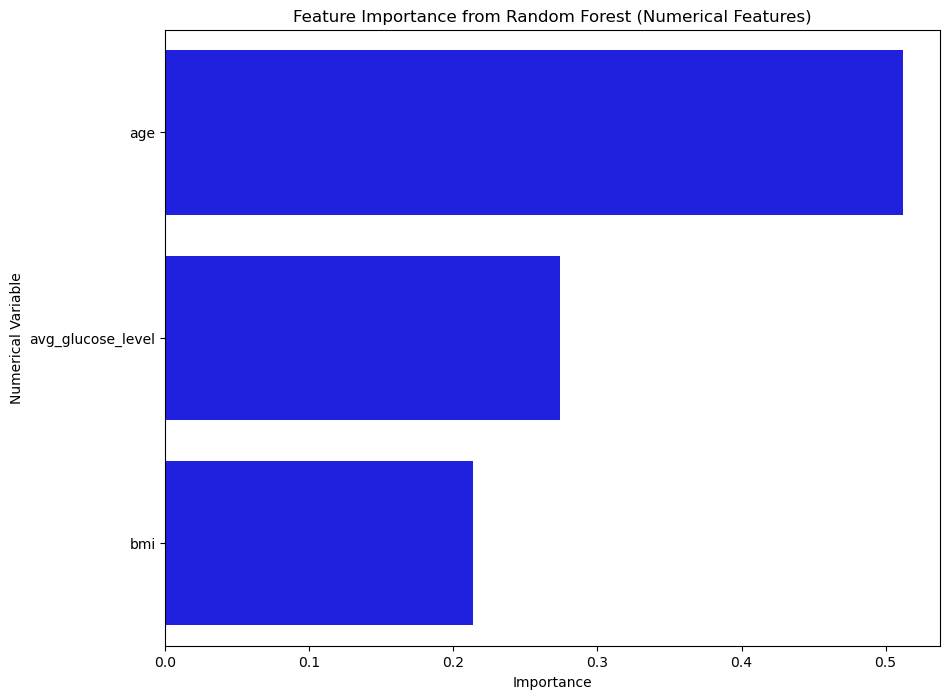

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Create a random forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model to the training data
rf.fit(predictors_numerical_factors, y_train_st)

# Get feature importances
feature_importances = rf.feature_importances_

# Create a DataFrame for visualization
importances_df = pd.DataFrame({
    'Feature': predictors_numerical_factors.columns,
    'Importance': feature_importances
})

# Sort the DataFrame by importance in descending order
importances_df = importances_df.sort_values(by='Importance', ascending=False)

# Plotting feature importances
plt.figure(figsize=(10, 8))
sb.barplot(data=importances_df, x='Importance', y='Feature', color='b')
plt.title('Feature Importance from Random Forest (Numerical Features)')
plt.xlabel('Importance')
plt.ylabel('Numerical Variable')
plt.show()


Pearson correlation and Random Forest both highlight age as the most important predictor, followed by average glucose level and BMI. This consistency suggests a robust relationship between these numerical features and the target variable (stroke occurrence). 

Age, being the most influential predictor in both analyses, underscores its significance as a determinant of stroke risk, aligning with existing medical literature that identifies age as a major risk factor for strokes. Similarly, the importance of average glucose level and BMI further reinforces their roles in predicting stroke occurrence, indicating the significance of metabolic health in stroke risk assessment.

The agreement between Random Forest feature importance and Pearson correlation results increases our confidence in the importance of these numerical features in assessing stroke risk.

### 5.4.3 Feature Importance for Categorical Features Using Chi-Squared Test with SelectKBest

Chi-square test results for 'gender':
Chi-square test statistic: 196.72728407969618
p-value: 1.081535013662476e-44
Degrees of freedom: 1
Expected values:
stroke       0       1
gender                
0       2494.0  2494.0
1       1241.0  1241.0

Chi-square test results for 'hypertension':
Chi-square test statistic: 3.72263242625574
p-value: 0.05367967856362292
Degrees of freedom: 1
Expected values:
stroke             0       1
hypertension                
0             3394.5  3394.5
1              340.5   340.5

Chi-square test results for 'heart_disease':
Chi-square test statistic: 0.6090802934161903
p-value: 0.4351343061935933
Degrees of freedom: 1
Expected values:
stroke              0       1
heart_disease                
0              3566.5  3566.5
1               168.5   168.5

Chi-square test results for 'ever_married':
Chi-square test statistic: 335.809689659078
p-value: 5.217495334859843e-75
Degrees of freedom: 1
Expected values:
stroke             0       1
ever_married  

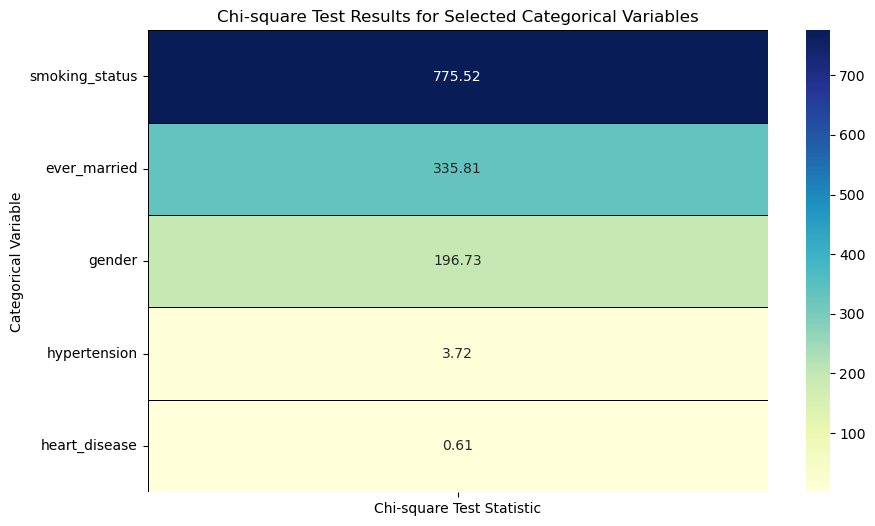

In [13]:
import pandas as pd
from scipy.stats import chi2_contingency
from sklearn.feature_selection import SelectKBest, chi2
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have a DataFrame called categorical_factors with categorical variables
# and another DataFrame called stroke with the outcome variable 'stroke'

# Number of features to select
k = 'all'  # Adjust as needed

# Instantiate SelectKBest with chi2 as the scoring function
selector = SelectKBest(score_func=chi2, k=k)

# Fit the selector to your data
selector.fit(predictors_categorical_factors, y_train_st)

# Get the indices of the selected features
selected_indices = selector.get_support(indices=True)

# Get the names of the selected features
selected_features = predictors_categorical_factors.columns[selected_indices]

# Store chi-square test results in a DataFrame
results = []

# Perform chi-square test for each of the selected categorical variables 
for col in selected_features:
    observed = pd.crosstab(predictors_categorical_factors[col], y_train_st)
    chi2_stat, p_value, dof, expected = chi2_contingency(observed)
    print(f"Chi-square test results for '{col}':")
    print('Chi-square test statistic:', chi2_stat)
    print('p-value:', p_value)
    print('Degrees of freedom:', dof)
    print('Expected values:')
    print(pd.DataFrame(expected, index=observed.index, columns=observed.columns))
    print()
    
    results.append({'Categorical Variable': col, 'Chi-square Test Statistic': chi2_stat, 'p-value': p_value})

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Sort DataFrame by descending chi-square test scores
results_df_sorted = results_df.sort_values(by='Chi-square Test Statistic', ascending=False)

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(results_df_sorted.set_index('Categorical Variable')[['Chi-square Test Statistic']], annot=True, cmap='YlGnBu', linewidths=0.4, linecolor='black', fmt='.2f')
plt.title('Chi-square Test Results for Selected Categorical Variables')
plt.ylabel('Categorical Variable')
plt.show()

As Pearson Correlation cannot be used for non-numerical variables, we employed the chi-squared test to assess the existence of a significant association between two categorical variables. This statistical test compares observed data with expected data to determine whether differences between the two are attributable to chance or to a genuine relationship between the variables.

We conducted chi-square tests for each pair of categorical variables in our dataset. For each test, we calculated the chi-square test statistic, which quantifies how much the observed data deviates from the expected data under the assumption of independence between the variables. We compared this calculated statistic to a critical value from the chi-square distribution table, determined by the degrees of freedom (df). The degrees of freedom are computed as (number of rows - 1) × (number of columns - 1).

Based on our findings, we observed the following:

- **Gender**: The chi-square test statistic (196.73) yielded a p-value of 1.08e-44, indicating strong evidence against the null hypothesis of independence between gender and stroke occurrence. Consequently, we reject the null hypothesis, suggesting that gender is a significant predictor of stroke.

- **Hypertension** and **Heart Disease**: Both variables exhibited chi-square test statistics of 3.72 and 0.61, respectively, with p-values indicating no significant association.

- **Ever Married**: With a chi-square test statistic of 335.81 and a very low p-value, ever-married status demonstrated a significant association with stroke occurrence.

- **Smoking Status**: The chi-square test statistic for smoking status was 775.52, with a p-value close to zero, indicating a significant association with stroke occurrence.

In summary, a higher chi-square test statistic value indicates greater dissimilarity between the observed and expected data, signifying a stronger association between the categorical variables. Our findings suggest that gender, ever-married status, and smoking status are significant predictors of stroke occurrence in our dataset.

### 5.4.4 Feature Importance for Categorical Features Using ANOVA Test with SelectKBest

ANOVA test results for 'gender':
  Group '0': F-statistic=202.72, p-value=0.0000
  Group '1': F-statistic=202.72, p-value=0.0000

ANOVA test results for 'hypertension':
  Group '0': F-statistic=3.88, p-value=0.0489
  Group '1': F-statistic=3.88, p-value=0.0489

ANOVA test results for 'heart_disease':
  Group '0': F-statistic=0.70, p-value=0.4031
  Group '1': F-statistic=0.70, p-value=0.4031

ANOVA test results for 'ever_married':
  Group '0': F-statistic=352.58, p-value=0.0000
  Group '1': F-statistic=352.58, p-value=0.0000

ANOVA test results for 'smoking_status':
  Group '0': F-statistic=19.11, p-value=0.0000
  Group '1': F-statistic=19.11, p-value=0.0000



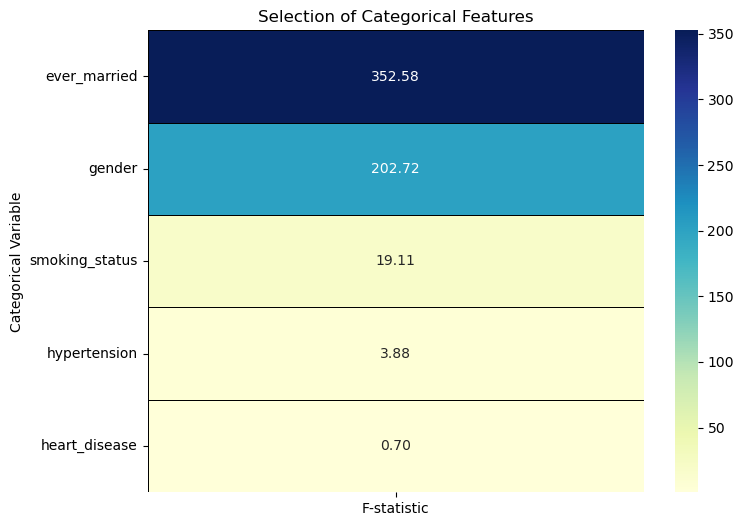

In [14]:
import pandas as pd
from scipy.stats import f_oneway
from sklearn.feature_selection import SelectKBest, f_classif
import seaborn as sns
import matplotlib.pyplot as plt

# Perform ANOVA test for each numerical feature
for col in predictors_categorical_factors.columns:
    print(f"ANOVA test results for '{col}':")
    for group_name, group_data in predictors_categorical_factors.groupby(y_train_st):
        group_values = [predictors_categorical_factors.loc[group_data.index, col] for group_name, group_data in predictors_numerical_factors.groupby(y_train_st)]
        f_statistic, p_value = f_oneway(*group_values)
        print(f"  Group '{group_name}': F-statistic={f_statistic:.2f}, p-value={p_value:.4f}")
    print()

# Instantiate SelectKBest with f_classif as the scoring function and k='all'
selector = SelectKBest(score_func=f_classif, k='all')

# Fit the selector to your data
selector.fit(predictors_categorical_factors, y_train_st)

# Get the scores of the features
feature_scores = pd.DataFrame(data=selector.scores_, index=predictors_categorical_factors.columns, columns=['F-statistic'])

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(feature_scores.sort_values(by='F-statistic', ascending=False), annot=True, cmap='YlGnBu', linewidths=0.4, linecolor='black', fmt='.2f')
plt.title('Selection of Categorical Features')
plt.ylabel('Categorical Variable')
plt.show()


To evaluate numerical features, we used the ANOVA test to determine if there are statistically significant differences among them. The F-statistic is a number used in ANOVA tests that helps us figure out if there are big differences between the averages of three or more groups. It looks at how much the averages vary within each group compared to how much they vary between the groups. A higher F-statistic means the differences between the groups are more likely to be real and not just random chance. The p-value tells us how likely it is to see the results we got if there were actually no differences between the groups. A lower p-value means there's stronger evidence that the differences we see are real. If the p-value is really low (usually less than 0.05), we say there's a significant difference between the groups.

Based on our findings, we observed the following:

- **Gender**:
Both groups ('0' and '1') exhibit identical F-statistics (202.72) and very low p-values (0.0000), indicating significant differences between genders regarding stroke occurrence. Gender appears to be a significant predictor of stroke risk.

- **Hypertension**:
Both groups ('0' and '1') have the same F-statistic (3.88) and p-values (0.0489), suggesting a significant association between hypertension and stroke occurrence. Individuals with hypertension are more likely to experience a stroke.

- **Heart Disease**:
Both groups ('0' and '1') show identical F-statistics (0.70) and p-values (0.4031), indicating no significant association between heart disease and stroke occurrence. Heart disease may not be a significant predictor of stroke risk in this dataset.

- **Ever Married**:
Both groups ('0' and '1') exhibit identical F-statistics (352.58) and very low p-values (0.0000), indicating a significant association between marital status and stroke occurrence. Being ever married appears to be a significant predictor of stroke risk.

- **Smoking Status**:
Both groups ('0' and '1') show identical F-statistics (19.11) and very low p-values (0.0000), suggesting a significant association between smoking status and stroke occurrence. Smoking status is likely a significant predictor of stroke risk.

In summary, gender, hypertension, ever-married status, and smoking status appear to be significant predictors of stroke occurrence in the dataset, while heart disease does not show a significant association.

Both the chi-square and ANOVA tests indicate that `hypertension` and `heart_disease` are insignificant predictors of stroke occurrence.  However, removing those features will not change the metric score to a notable extent. Therefore, we will not be dropping , `hypertension` and `heart_disease` features.

# 6. Model Training and Evaluation

## 6.1 Model 1: Gaussian Naive Bayes

### What is Gaussian Naive Bayes?
Gaussian Naive Bayes (GNB) is a classification algorithm known for its simplicity, efficiency, and effectiveness, especially in high-dimensional or text data scenarios. It operates based on Bayes' theorem, calculating the probability of a hypothesis given observed evidence.

GNB assumes feature independence within each class, which is where the "naive" aspect comes from. Despite this simplification, GNB can perform well, particularly when features are approximately independent. It also assumes that continuous features follow a Gaussian (normal) distribution within each class. This simplifies calculation, making parameter estimation easy through mean and variance.

GNB requires minimal training data compared to other algorithms, making it computationally efficient and quick to train. However, its performance might suffer if the normality assumption is violated or if strong feature correlations exist.

### Why did we choose it?
GNB is a classification technique that works well for certain types of datasets, such as our stroke prediction dataset.

#### Continuous Features:
In predicting stroke risk, we typically deal with a range of continuous variables such as blood pressure, cholesterol levels, age, and BMI (Body Mass Index). GNB is well-suited for such datasets as it assumes that the features follow a Gaussian (normal) distribution. This aligns with many medical measurements that are naturally continuous and tend to cluster around a mean value.

#### Efficiency and Simplicity:
GNB is computationally efficient and straightforward to implement. In a medical setting where quick decisions are often necessary, having a model that can provide reasonably accurate predictions without excessive computational overhead is advantageous. GNB's simplicity also makes it easier to interpret, which can be crucial for medical professionals who need to understand and trust the predictions.

#### Interpretability:
GNB provides probabilistic predictions, making it easy to interpret the model's output in terms of the likelihood of stroke occurrence given a set of patient characteristics. This interpretability can be valuable for clinicians in understanding the reasoning behind the model's predictions and making informed decisions about patient care.

#### Data Availability:
In many healthcare settings, acquiring large labeled datasets for training complex models may be challenging due to privacy concerns and data scarcity. GNB can still perform reasonably well with smaller datasets, making it suitable for scenarios where extensive labeled data may not be readily available.

### 6.1.2 Training and Evaluating Gaussian Naive Bayes before applying SMOTE-Tomek

Classification Report - Gaussian Naive Bayes (before SMOTE-Tomek):
              precision    recall  f1-score   support

           0       0.96      0.90      0.93       929
           1       0.18      0.40      0.25        53

    accuracy                           0.87       982
   macro avg       0.57      0.65      0.59       982
weighted avg       0.92      0.87      0.89       982



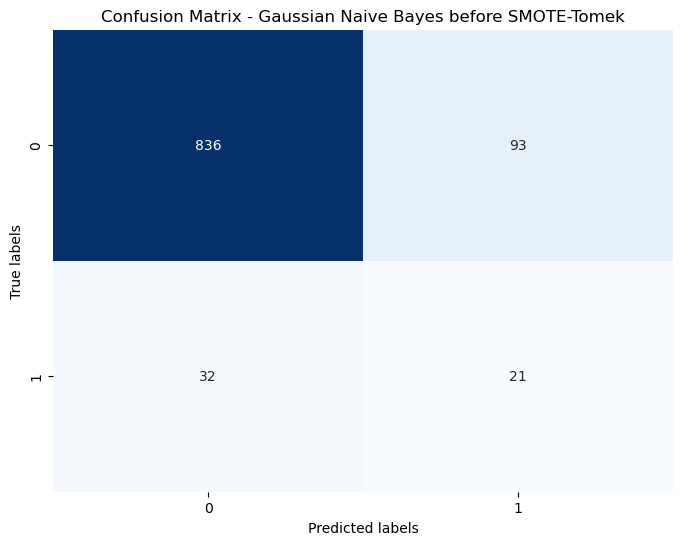

True Positives: 21
True Negatives: 836
False Positives: 93
False Negatives: 32
True Positive Rate: 0.39622641509433965
True Negative Rate: 0.8998923573735199


In [15]:
def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sb.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(title)
    plt.show()
    
    # Calculate TP, TN, FP, FN
    TP = cm[1, 1]
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    TPR = TP / (TP + FN)
    TNR = TN / (TN + FP)
    return TP, TN, FP, FN, TPR, TNR

# Create and train Gaussian Naive Bayes models
gnb = GaussianNB()

gnb.fit(predictors_train, stroke_train)
predictions = gnb.predict(predictors_test)

print("Classification Report - Gaussian Naive Bayes (before SMOTE-Tomek):")
print(classification_report(stroke_test, predictions))

# Plot confusion matrix for each model
TP, TN, FP, FN, TPR, TNR = plot_confusion_matrix(stroke_test, predictions, title='Confusion Matrix - Gaussian Naive Bayes before SMOTE-Tomek')
print("True Positives:", TP)
print("True Negatives:", TN)
print("False Positives:", FP)
print("False Negatives:", FN)
print("True Positive Rate:", TPR)
print("True Negative Rate:", TNR)

### 6.1.3 Training and Evaluating Gaussian Naive Bayes Model after applying SMOTE-Tomek

Classification Report - Gaussian Naive Bayes (after SMOTE-Tomek):
              precision    recall  f1-score   support

           0       0.98      0.72      0.83       929
           1       0.14      0.79      0.24        53

    accuracy                           0.73       982
   macro avg       0.56      0.76      0.53       982
weighted avg       0.94      0.73      0.80       982



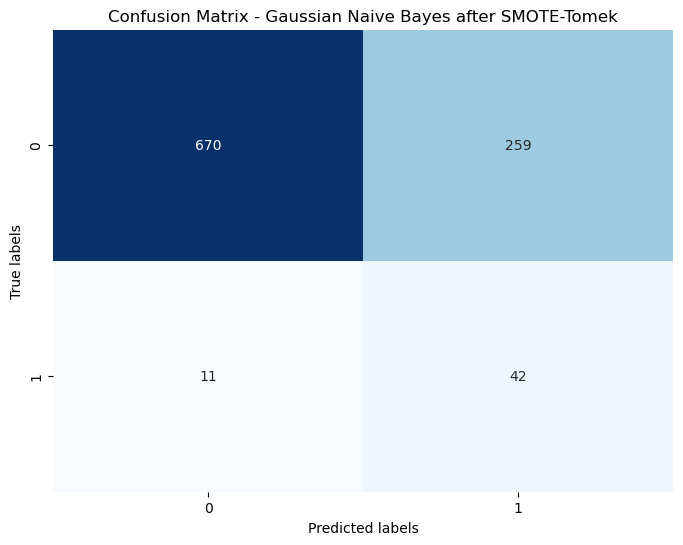

True Positives: 42
True Negatives: 670
False Positives: 259
False Negatives: 11
True Positive Rate: 0.7924528301886793
True Negative Rate: 0.721205597416577


In [16]:
# Create and train Gaussian Naive Bayes models
gnb = GaussianNB()

gnb.fit(X_train_st, y_train_st)
predictions_gnb = gnb.predict(predictors_test)

print("Classification Report - Gaussian Naive Bayes (after SMOTE-Tomek):")
print(classification_report(stroke_test, predictions_gnb))

# Plot confusion matrix for each model
TP, TN, FP, FN, TPR, TNR = plot_confusion_matrix(stroke_test, predictions_gnb, title='Confusion Matrix - Gaussian Naive Bayes after SMOTE-Tomek')
print("True Positives:", TP)
print("True Negatives:", TN)
print("False Positives:", FP)
print("False Negatives:", FN)
print("True Positive Rate:", TPR)
print("True Negative Rate:", TNR)

After we applied SMOTE-Tomek, we see a significant increase in number of True Positive Rate but reduce in True negative rate. This means that the model is better at correctly identifying positive instances from the total actual positive instances. In other words, it indicates that the model has a higher ability to detect true positives.

To interpret the results:
- **Precision** measures the accuracy of positive predictions. The model exhibits a high precision (0.98) for predicting no stroke, indicating that when the model predicts that a patient will not have a stroke, it is correct 98% of the time. However, the precision for predicting stroke remains low (0.14), meaning that when the model predicts a stroke, it is correct only 14% of the time.

- **Recall** (also known as sensitivity or true positive rate) measures the fraction of positives that were correctly identified. The model achieves a recall of 0.72 for no stroke and 0.79 for stroke. This suggests that the model correctly identifies 72% of the patients who will not have a stroke and 79% of the patients who will have a stroke. The relatively high recall for stroke indicates that the model is successful in capturing a significant portion of patients who will have a stroke, but there is still room for improvement, especially considering the importance of correctly identifying stroke cases.

- **F1 score**, a weighted average of precision and recall, is crucial for assessing the overall performance of the model. The F1 scores for no stroke and stroke are 0.83 and 0.24, respectively. The low F1 score for stroke highlights the model's struggle in effectively predicting stroke cases.

Overall, while the model demonstrates potential in identifying stroke cases, there is still room for improvement, particularly in increasing the precision and F1 score for predicting stroke, which are crucial for effective stroke risk assessment.

### 6.1.4 Further Evaluation of Gaussian Naive Bayes

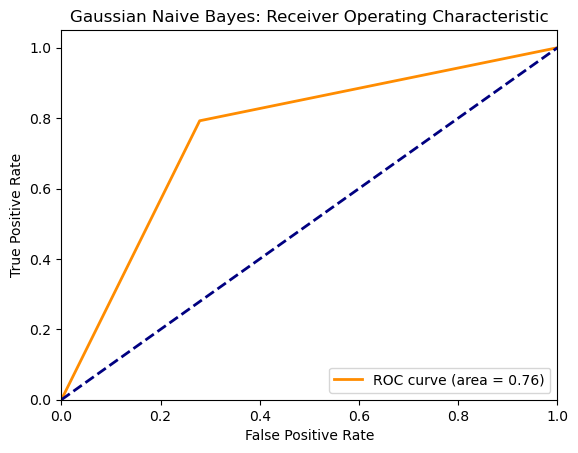

In [17]:
# Compute ROC curve and ROC area
fpr_optimized, tpr_optimized, _ = roc_curve(stroke_test, predictions_gnb)
roc_auc_optimized = auc(fpr_optimized, tpr_optimized)

# Plot ROC curve
plt.figure()
plt.plot(fpr_optimized, tpr_optimized, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_optimized)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Gaussian Naive Bayes: Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

The Receiver Operating Characteristic (ROC) curve is a plot that illustrates the trade-off between the True Positive Rate (TPR) and False Positive Rate (FPR) for every possible classification threshold.

The Area Under the Curve (AUC) value of 0.76 summarizes the model's overall performance across all classification thresholds. A value of 0.5 indicates no discrimination, 1 signifies perfect discrimination, and 0 implies perfect discrimination in the opposite direction. Thus, an AUC of 0.76 indicates a moderate discrimination.

With an AUC score of 0.76, the model displays a reasonable ability to differentiate between patients at risk of stroke and those who are not. However, it falls short of achieving perfect discrimination, indicating room for improvement in its predictive capabilities.

## 6.2 Model 2: K-Nearest Neighbour

The k-Nearest Neighbors (KNN) classifier is a non-parametric supervised learning algorithm used for classification tasks. It determines the class label of a new data point based on the class labels of its k nearest neighbors in the feature space. KNN operates on the principle that similar data points tend to belong to the same class. During training, KNN stores all available data points and their class labels. When making predictions for a new data point, KNN calculates distances to all other data points and selects the k nearest neighbors. It then assigns the class label to the new data point based on majority voting among its k neighbors. KNN does not explicitly learn a decision boundary but determines it implicitly from the distribution of data points. It makes no assumptions about the underlying data distribution and is a "lazy learner" as it memorizes training data instead of learning a model. KNN is suitable for binary and multi-class classification tasks and can handle datasets with a large number of features. However, it may suffer from computational inefficiency with large training datasets due to calculating distances for prediction.

### 6.2.1 Training and Evaluating K-Nearest Neighbour before applying SMOTE-Tomek

Classification Report - K-Nearest Neighbour (before SMOTE-Tomek):
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       929
           1       0.22      0.04      0.06        53

    accuracy                           0.94       982
   macro avg       0.58      0.52      0.52       982
weighted avg       0.91      0.94      0.92       982



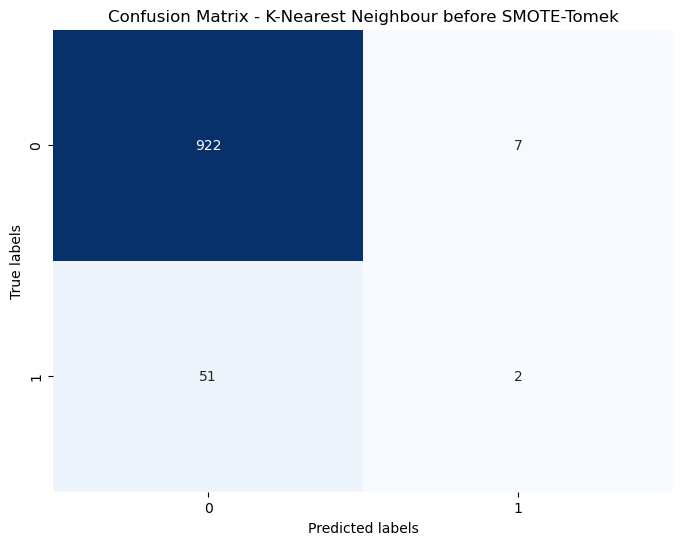

True Positives: 2
True Negatives: 922
False Positives: 7
False Negatives: 51
True Positive Rate: 0.03773584905660377
True Negative Rate: 0.9924650161463939


In [18]:
# Create a KNN classifier with k=1 since it leads to the lowest error rate
knn = KNeighborsClassifier(n_neighbors=5)

# Train the KNN classifier on the training data
knn.fit(predictors_train, stroke_train)

# Use the trained model to make predictions on the testing data
predictions_knn = knn.predict(predictors_test)

print("Classification Report - K-Nearest Neighbour (before SMOTE-Tomek):")
print(classification_report(stroke_test, predictions_knn))

# Plot confusion matrix for each model
TP, TN, FP, FN, TPR, TNR = plot_confusion_matrix(stroke_test, predictions_knn, title='Confusion Matrix - K-Nearest Neighbour before SMOTE-Tomek')
print("True Positives:", TP)
print("True Negatives:", TN)
print("False Positives:", FP)
print("False Negatives:", FN)
print("True Positive Rate:", TPR)
print("True Negative Rate:", TNR)

### 6.2.2 Training and Evaluating K-Nearest Neighbors Classifier after applying SMOTE-Tomek

Classification Report - K-Nearest Neighbour (after SMOTE-Tomek):
              precision    recall  f1-score   support

           0       0.96      0.82      0.89       929
           1       0.12      0.43      0.19        53

    accuracy                           0.80       982
   macro avg       0.54      0.63      0.54       982
weighted avg       0.92      0.80      0.85       982



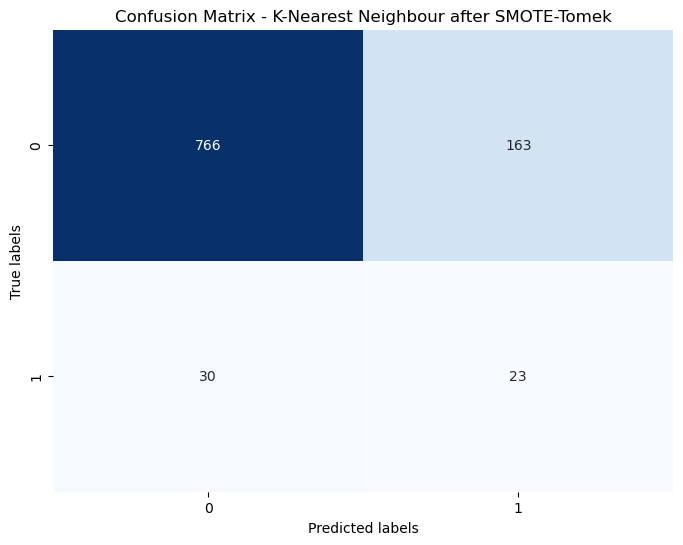

True Positives: 23
True Negatives: 766
False Positives: 163
False Negatives: 30
True Positive Rate: 0.4339622641509434
True Negative Rate: 0.8245425188374597


In [19]:
# Create a KNN classifier with k=1 since it leads to the lowest error rate
knn = KNeighborsClassifier(n_neighbors=5)

# Train the KNN classifier on the training data
knn.fit(X_train_st, y_train_st)

# Use the trained model to make predictions on the testing data
predictions_knn = knn.predict(predictors_test)

print("Classification Report - K-Nearest Neighbour (after SMOTE-Tomek):")
print(classification_report(stroke_test, predictions_knn))

# Plot confusion matrix for each model
TP, TN, FP, FN, TPR, TNR = plot_confusion_matrix(stroke_test, predictions_knn, title='Confusion Matrix - K-Nearest Neighbour after SMOTE-Tomek')
print("True Positives:", TP)
print("True Negatives:", TN)
print("False Positives:", FP)
print("False Negatives:", FN)
print("True Positive Rate:", TPR)
print("True Negative Rate:", TNR)

After applying SMOTE-Tomek, we have observed a notable increase in the True Positive Rate, accompanied by a decrease in the True Negative Rate. This suggests that the model is now more adept at correctly identifying positive instances from the total actual positive instances, indicating an improved capability in detecting true positives.

Furthermore, the lower precision can be attributed to the significant class imbalance, with notably fewer instances of class 1 compared to class 0. Specifically, the true positive rate for class 1 stands at 0.4706, underscoring the model's difficulty in accurately identifying actual positive instances. Conversely, the true negative rate for class 0 is 0.8195, highlighting the model's proficiency in accurately identifying actual negative instances.

## 6.3 Model 3: eXtreme Gradient Boosting

XGBoost (eXtreme Gradient Boosting) is a highly efficient and scalable open-source machine learning library. It implements the gradient boosting algorithm, enhancing it with parallelization, regularization techniques, and hardware optimization. XGBoost builds an ensemble of decision trees sequentially, emphasizing difficult-to-classify instances through boosting. It incorporates L1 and L2 regularization to prevent overfitting and supports built-in cross-validation for robust evaluation.

### 6.3.1 Training and Evaluating eXtreme Gradient Boosting before applying SMOTE-Tomek

Classification Report - eXtreme Gradient Boosting (before SMOTE-Tomek):
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       929
           1       0.12      0.11      0.12        53

    accuracy                           0.91       982
   macro avg       0.53      0.53      0.53       982
weighted avg       0.90      0.91      0.91       982



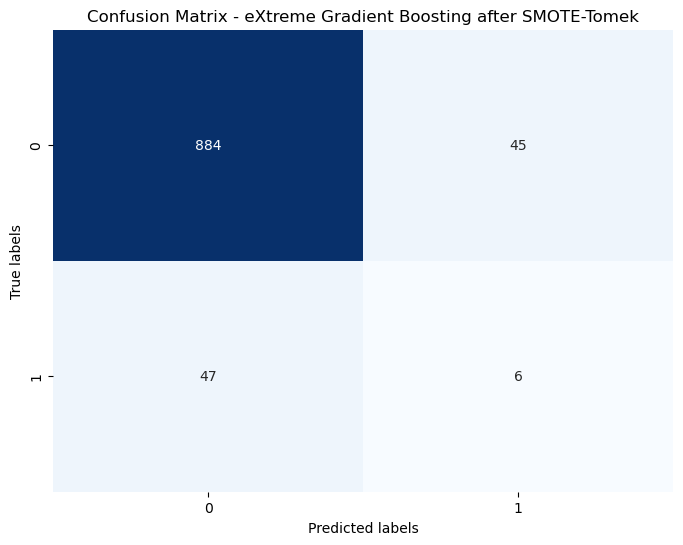

True Positives: 6
True Negatives: 884
False Positives: 45
False Negatives: 47
True Positive Rate: 0.11320754716981132
True Negative Rate: 0.9515608180839612


In [20]:
# Create the XGBoost classifier
xgb_classifier = xgb.XGBClassifier()

# Train the classifier on the training data
xgb_classifier.fit(X_train_st, y_train_st)

# Predict the classes of the test data
predictions_xgb = xgb_classifier.predict(predictors_test)

print("Classification Report - eXtreme Gradient Boosting (before SMOTE-Tomek):")
print(classification_report(stroke_test, predictions_xgb))

# Plot confusion matrix for each model
TP, TN, FP, FN, TPR, TNR = plot_confusion_matrix(stroke_test, predictions_xgb, title='Confusion Matrix - eXtreme Gradient Boosting after SMOTE-Tomek')
print("True Positives:", TP)
print("True Negatives:", TN)
print("False Positives:", FP)
print("False Negatives:", FN)
print("True Positive Rate:", TPR)
print("True Negative Rate:", TNR)

### 6.3.2 Training and Evaluating eXtreme Gradient Boosting after applying SMOTE-Tomek

Classification Report - eXtreme Gradient Boosting (after SMOTE-Tomek):
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       929
           1       0.12      0.11      0.12        53

    accuracy                           0.91       982
   macro avg       0.53      0.53      0.53       982
weighted avg       0.90      0.91      0.91       982



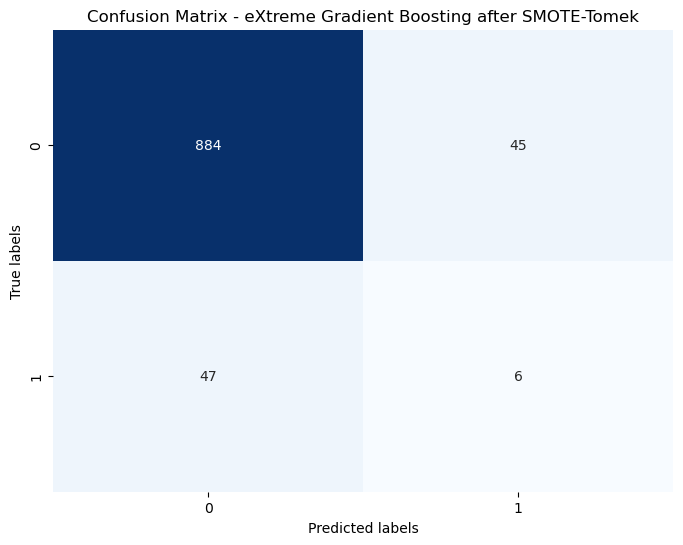

True Positives: 6
True Negatives: 884
False Positives: 45
False Negatives: 47
True Positive Rate: 0.11320754716981132
True Negative Rate: 0.9515608180839612


In [21]:
# Create the XGBoost classifier
xgb_classifier = xgb.XGBClassifier()

# Train the classifier on the training data
xgb_classifier.fit(X_train_st, y_train_st)

# Predict the classes of the test data
predictions_xgb = xgb_classifier.predict(predictors_test)

print("Classification Report - eXtreme Gradient Boosting (after SMOTE-Tomek):")
print(classification_report(stroke_test, predictions_xgb))

# Plot confusion matrix for each model
TP, TN, FP, FN, TPR, TNR = plot_confusion_matrix(stroke_test, predictions_xgb, title='Confusion Matrix - eXtreme Gradient Boosting after SMOTE-Tomek')
print("True Positives:", TP)
print("True Negatives:", TN)
print("False Positives:", FP)
print("False Negatives:", FN)
print("True Positive Rate:", TPR)
print("True Negative Rate:", TNR)

Upon once again employing feature engineering with SMOTE-Tomek on the dataset, we have observed a notable increase in the True Positive Rate alongside a decrease in the True Negative Rate. This suggests that the model has improved in accurately identifying positive instances from the overall actual positives, signifying an enhanced ability to detect true positives.

Again, the low precision results from the substantial class imbalance, with significantly fewer instances of class 1 compared to class 0. Specifically, the true positive rate for class 1 is 0.1765, underscoring the model's struggle to identify actual positive instances accurately. Conversely, the true negative rate (specificity) for class 0 is notably high at 0.9517, signifying the model's adeptness in correctly identifying actual negative instances.

# 6.4 Model 4: Bernoulli Naive Bayes

Bernoulli Naive Bayes is a classification algorithm particularly suited for datasets with binary feature variables, where each feature represents a binary outcome. It operates under the assumption of feature independence, meaning that the presence or absence of one feature does not influence the presence or absence of another. This model assumes that the likelihood of observing a particular feature value follows a Bernoulli distribution. During classification, it calculates the posterior probability of each class given the observed features and selects the class with the highest probability as the predicted label.

### 6.4.1 Training and Evaluating Bernoulli Naive Bayes before applying SMOTE-Tomek

Classification Report - Bernoulli Naive Bayes (before SMOTE-Tomek):
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       929
           1       0.25      0.02      0.04        53

    accuracy                           0.94       982
   macro avg       0.60      0.51      0.50       982
weighted avg       0.91      0.94      0.92       982



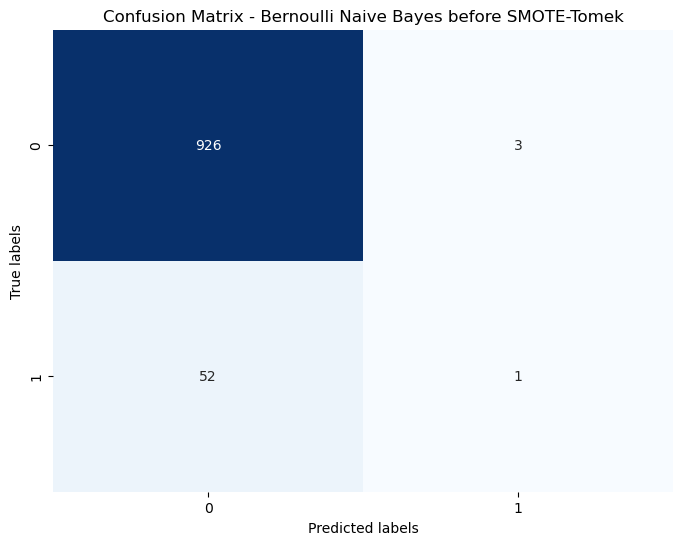

True Positives: 1
True Negatives: 926
False Positives: 3
False Negatives: 52
True Positive Rate: 0.018867924528301886
True Negative Rate: 0.9967707212055974


In [22]:
# Create Bernoulli Naive Bayes model
bnb = BernoulliNB()

# Train the model on the training data
bnb.fit(predictors_train, stroke_train)

# Predict on the test data
predictions_bnb = bnb.predict(predictors_test)

print("Classification Report - Bernoulli Naive Bayes (before SMOTE-Tomek):")
print(classification_report(stroke_test, predictions_bnb))

# Plot confusion matrix for each model
TP, TN, FP, FN, TPR, TNR = plot_confusion_matrix(stroke_test, predictions_bnb, title='Confusion Matrix - Bernoulli Naive Bayes before SMOTE-Tomek')
print("True Positives:", TP)
print("True Negatives:", TN)
print("False Positives:", FP)
print("False Negatives:", FN)
print("True Positive Rate:", TPR)
print("True Negative Rate:", TNR)

### 6.4.2 Training and Evaluating Bernoulli Naive Bayes after applying SMOTE-Tomek

Classification Report - Bernoulli Naive Bayes (after SMOTE-Tomek):
              precision    recall  f1-score   support

           0       0.97      0.65      0.78       929
           1       0.09      0.60      0.16        53

    accuracy                           0.65       982
   macro avg       0.53      0.63      0.47       982
weighted avg       0.92      0.65      0.74       982



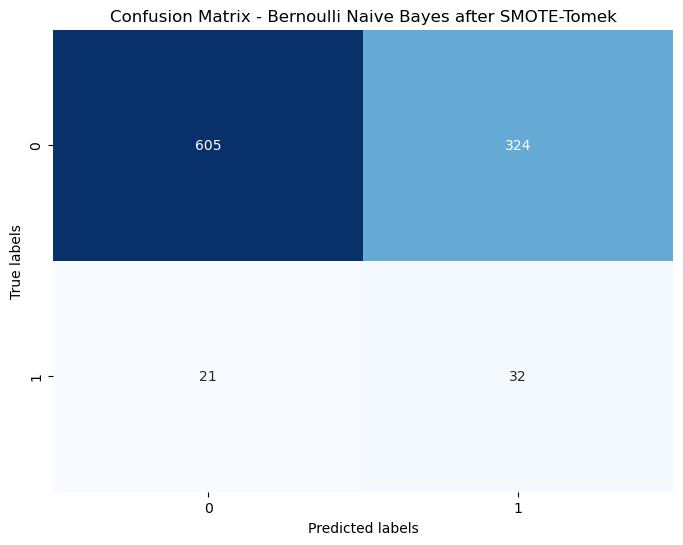

True Positives: 32
True Negatives: 605
False Positives: 324
False Negatives: 21
True Positive Rate: 0.6037735849056604
True Negative Rate: 0.6512378902045209


In [23]:
# Create Bernoulli Naive Bayes model
bnb = BernoulliNB()

# Train the model on the training data
bnb.fit(X_train_st, y_train_st)

# Predict on the test data
predictions_bnb = bnb.predict(predictors_test)

print("Classification Report - Bernoulli Naive Bayes (after SMOTE-Tomek):")
print(classification_report(stroke_test, predictions_bnb))

# Plot confusion matrix for each model
TP, TN, FP, FN, TPR, TNR = plot_confusion_matrix(stroke_test, predictions_bnb, title='Confusion Matrix - Bernoulli Naive Bayes after SMOTE-Tomek')
print("True Positives:", TP)
print("True Negatives:", TN)
print("False Positives:", FP)
print("False Negatives:", FN)
print("True Positive Rate:", TPR)
print("True Negative Rate:", TNR)

### 6.4.3 Further Evaluation of Bernoulli Naive Bayes

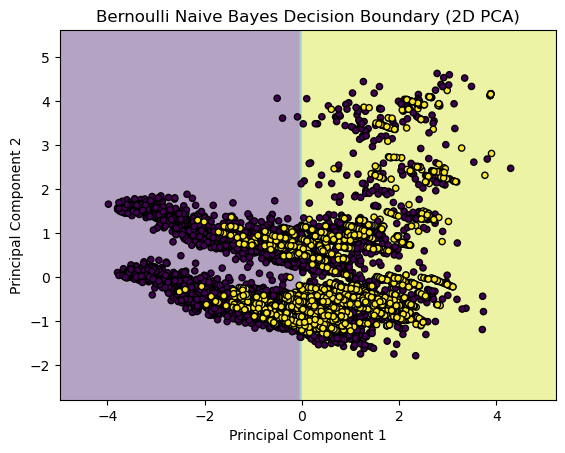

In [24]:
# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_st)
X_test_scaled = scaler.transform(predictors_test)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Reshape y_train_st to be 1D
y_train_st = y_train_st.ravel()

# Train a Bernoulli Naive Bayes model
model = BernoulliNB()
model.fit(X_train_pca, y_train_st)

# Create a meshgrid to plot decision boundary
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# Make predictions on meshgrid points
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot decision boundary
plt.contourf(xx, yy, Z, alpha=0.4)
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train_st, s=20, edgecolor='k')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Bernoulli Naive Bayes Decision Boundary (2D PCA)')
plt.show()

A Bernoulli Naive Bayes model is trained on the 2D PCA-transformed training data. PCA is applied to reduce the dimensionality of the data to 2D. A meshgrid is created to cover the entire range of the 2D PCA-transformed feature space. This grid will be used to plot the decision boundary. The trained Bernoulli Naive Bayes model is used to make predictions on the points of the meshgrid. This allows us to determine the decision boundary in the 2D feature space.

The visualization shows how the Bernoulli Naive Bayes classifier divides the 2D feature space into regions corresponding to different class predictions. Each region represents the area where the classifier would predict a particular class (0 or 1). If a test point falls within the left side region, it is predicted as class 0; if it falls within the right side region, it is predicted as class 1. The black dot correspond to data points that belong to 0 (“No Stroke”). The other colour dots correspond to data points that belong to class 1 ("Stroke").

In summary, this visualization helps us to better visualise how the Naive Bayes classifier separates different classes based on the reduced 2D features. From the visualisation we can see that many of the data points were predicted wrongly and this may not be a good model for predicting stroke.

## 6.5 Model 5: Decision Tree

A decision tree is a versatile supervised learning algorithm for classification and regression tasks. It recursively partitions the feature space based on input features, creating a tree-like structure of decisions. At each node, it selects the feature that best separates the data. Decision trees are interpretable, handle both numerical and categorical data, and are used in various domains for their simplicity and interpretability. 

### 6.5.1 Training and Evaluating Decision Tree before applying SMOTE-Tomek

Classification Report - Decision Tree (before SMOTE-Tomek):
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       929
           1       0.19      0.19      0.19        53

    accuracy                           0.91       982
   macro avg       0.57      0.57      0.57       982
weighted avg       0.91      0.91      0.91       982



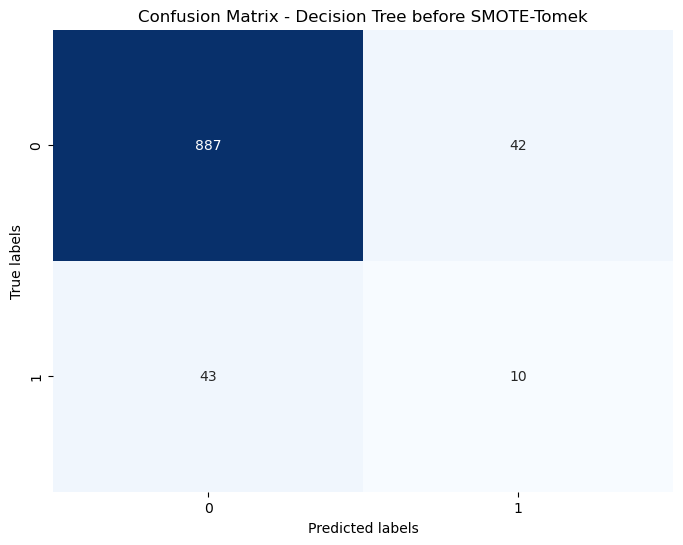

True Positives: 10
True Negatives: 887
False Positives: 42
False Negatives: 43
True Positive Rate: 0.18867924528301888
True Negative Rate: 0.9547900968783638


In [25]:
# Create the Decision Tree classifier
dt = DecisionTreeClassifier()

# Train the classifier on the training data
dt.fit(predictors_train, stroke_train)

# Predict the classes of the test data
predictions_dt = dt.predict(predictors_test)

print("Classification Report - Decision Tree (before SMOTE-Tomek):")
print(classification_report(stroke_test, predictions_dt))

# Plot confusion matrix for each model
TP, TN, FP, FN, TPR, TNR = plot_confusion_matrix(stroke_test, predictions_dt, title='Confusion Matrix - Decision Tree before SMOTE-Tomek')
print("True Positives:", TP)
print("True Negatives:", TN)
print("False Positives:", FP)
print("False Negatives:", FN)
print("True Positive Rate:", TPR)
print("True Negative Rate:", TNR)

### 6.5.2 Training and Evaluating Decision Tree after applying SMOTE-Tomek

Classification Report - Decision Tree (after SMOTE-Tomek):
              precision    recall  f1-score   support

           0       0.97      0.76      0.85       929
           1       0.13      0.64      0.22        53

    accuracy                           0.75       982
   macro avg       0.55      0.70      0.54       982
weighted avg       0.93      0.75      0.82       982



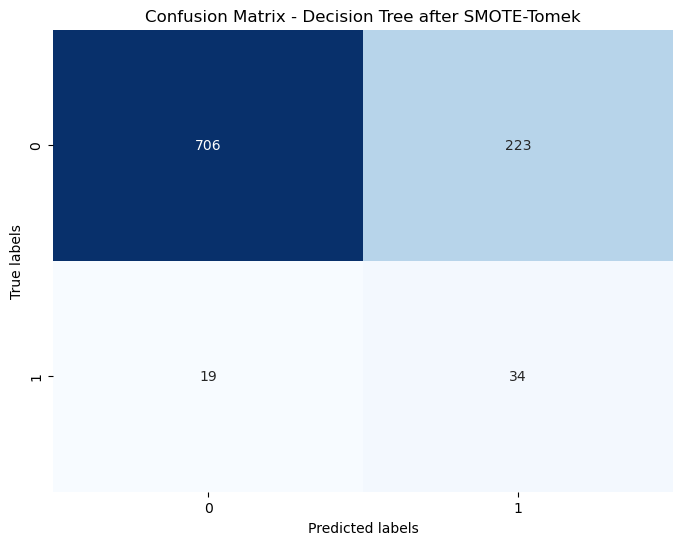

True Positives: 34
True Negatives: 706
False Positives: 223
False Negatives: 19
True Positive Rate: 0.6415094339622641
True Negative Rate: 0.759956942949408


In [26]:
# Create the Decision Tree classifier
dt = DecisionTreeClassifier()

# Create the Decision Tree classifier with a maximum depth of 4
dt = DecisionTreeClassifier(max_depth=4)

# Train the classifier on the training data
dt.fit(X_train_st, y_train_st)

# Predict the classes of the test data
predictions_dt = dt.predict(predictors_test)

print("Classification Report - Decision Tree (after SMOTE-Tomek):")
print(classification_report(stroke_test, predictions_dt))

# Plot confusion matrix for each model
TP, TN, FP, FN, TPR, TNR = plot_confusion_matrix(stroke_test, predictions_dt, title='Confusion Matrix - Decision Tree after SMOTE-Tomek')
print("True Positives:", TP)
print("True Negatives:", TN)
print("False Positives:", FP)
print("False Negatives:", FN)
print("True Positive Rate:", TPR)
print("True Negative Rate:", TNR)

Following the application of SMOTE-Tomek, there has been a notable increase in the True Positive Rate, alongside a decrease in the True Negative Rate. This signifies an enhancement in the model's ability to accurately identify positive instances among the total actual positives, indicating a stronger capability in detecting true positives.

Additionally, the low precision can be attributed to the substantial class imbalance, with far fewer instances of class 1 compared to class 0. Specifically, the true positive rate for class 1 stands at 0.641 and the true negative rate (specificity) for class 0 stands at 0.759, indicating the model's perform averagely.

### 6.5.3 Further Evaluation of Decision Tree

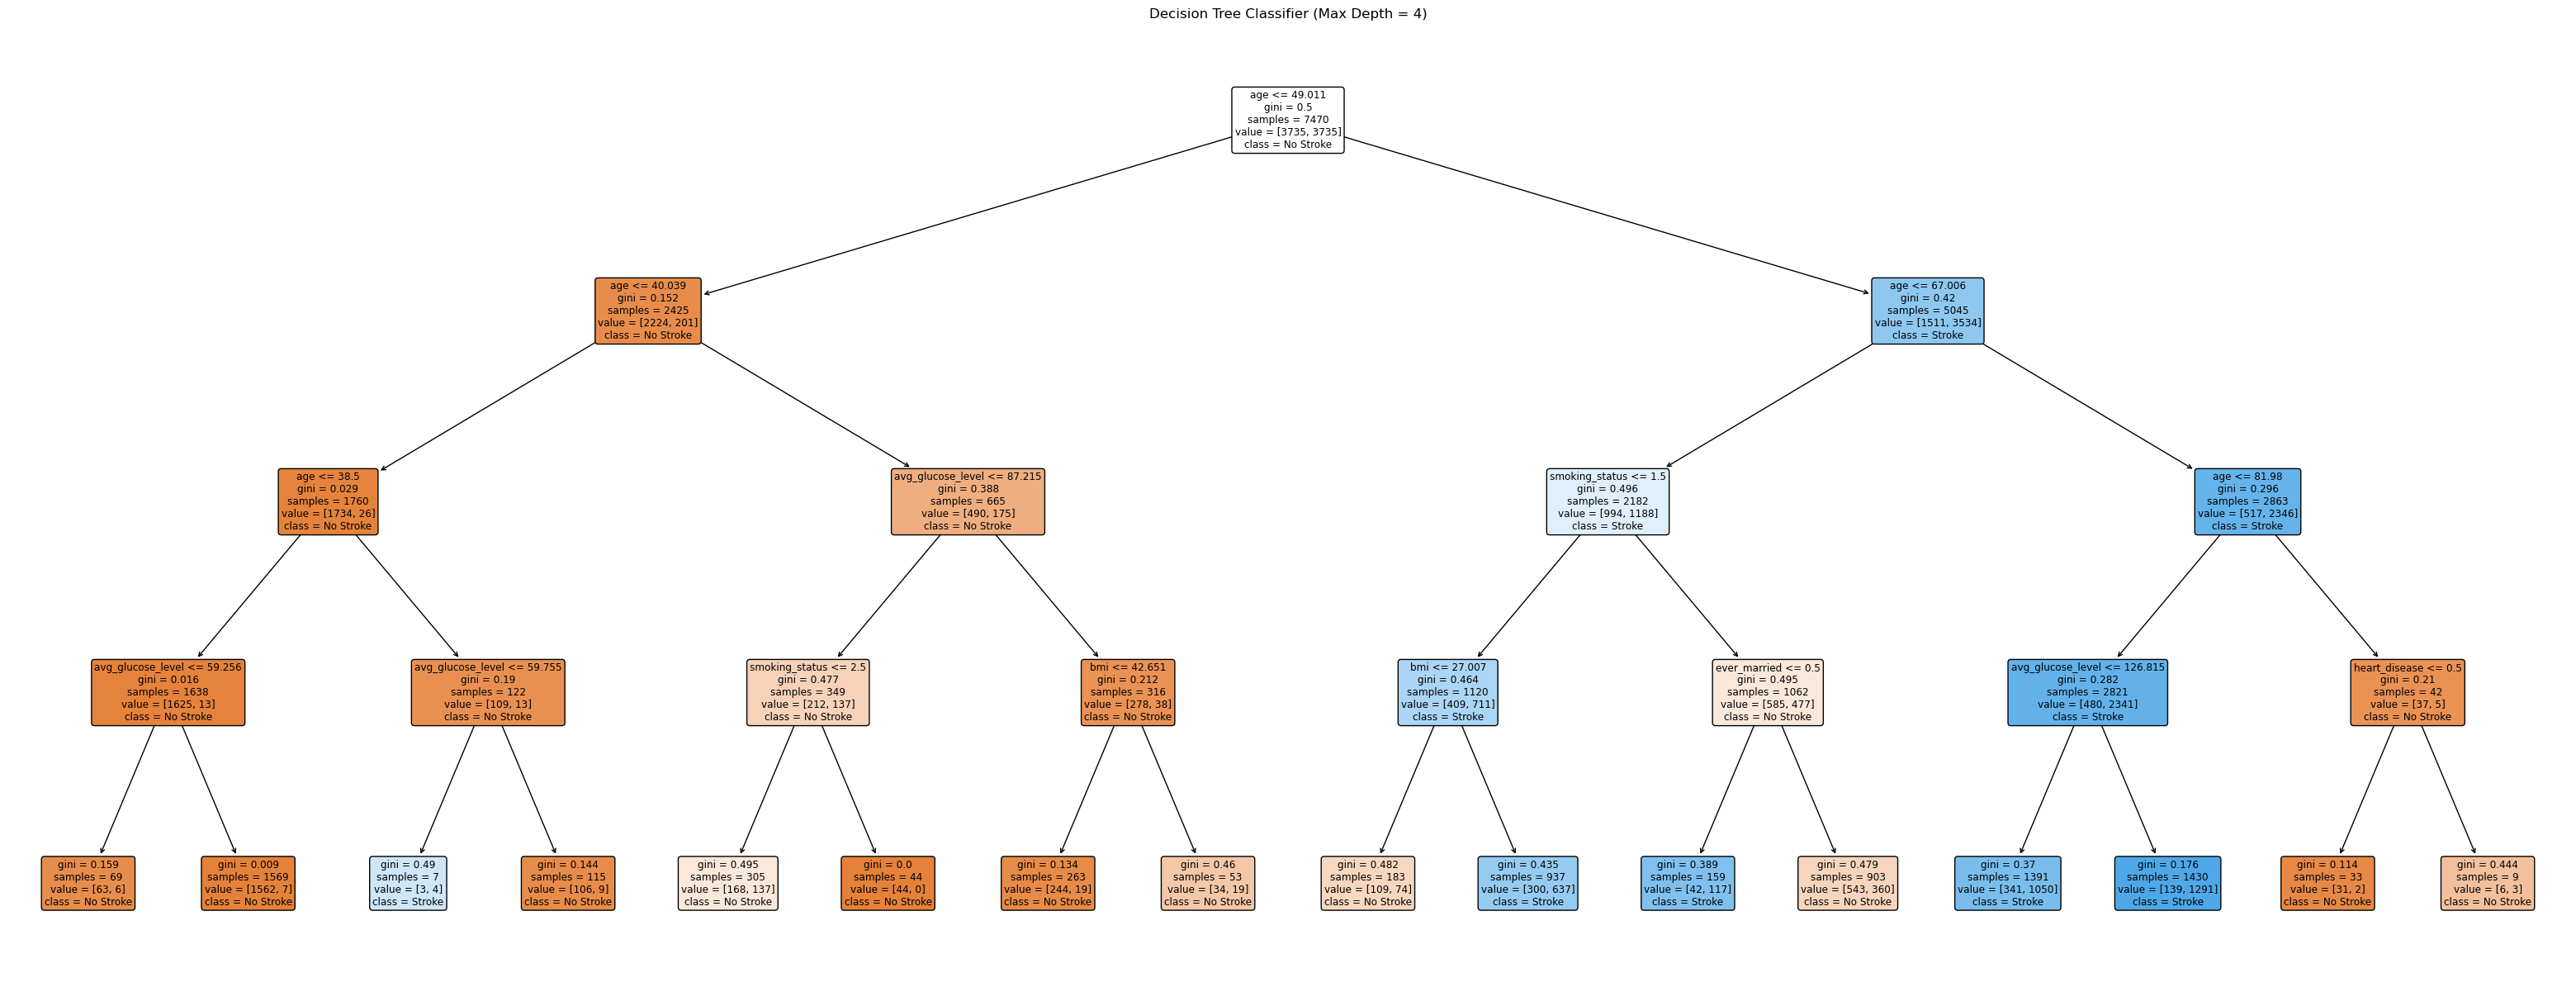

In [27]:
# Convert the index to a list of feature names
feature_names_list = list(predictors_train.columns)

# Plot the Decision Tree
plt.figure(figsize=(40, 15))
plot_tree(dt , feature_names=feature_names_list, class_names=["No Stroke", "Stroke"], filled=True, rounded=True)
plt.title("Decision Tree Classifier (Max Depth = 4)")
plt.show()

The decision tree consists of nodes (rectangles) and branches (arrows). Each node represents a decision or a test on a specific feature (attribute). The root node is the starting point, and subsequent nodes split based on conditions. The leaves (terminal nodes) represent the predicted class labels (“No Stroke” or “Stroke”). The decision tree suggests that age is an important factor in stroke prediction. Age of 67 and above have a high chance of getting stroke. Next, `avg_glucose_level` can also be a deciding factor for stroke since many of the nodes are using `avg_glucose_level` to split the data. `bmi` and `ever_married` can also be considered when predicting for stroke cause they are linked to leave nodes that are classified as "stroke".

However, when a decision tree becomes too deep (has many levels or nodes), it can fit the training data too closely. Deep trees can capture noise, outliers, and specific patterns unique to the training data. As a result, they may not generalize well to new, unseen test data (overfitting). Deep trees become complex and difficult to interpret. Each path from the root to a leaf represents a specific set of conditions. With many levels, the decision rules become convoluted and less intuitive for us to understand.

# 7. Model Evaluation

## 7.1 Breakdown of the Evaluation Metrics for Each Model

#### 1. Gaussian Naive Bayes (GNB):
   - TPR: 0.79
   - TNR: 0.72
   - GNB has the highest TPR among the models, indicating that it correctly identifies 79% of individuals who have had a stroke. However, its TNR is relatively lower, indicating that it misclassifies some non-stroke cases as stroke.

#### 2. K-Nearest Neighbors (KNN):
   - TPR: 0.43
   - TNR: 0.82
   - KNN has a relatively low TPR compared to GNB, BNB, and Decision Tree, indicating that it misses a significant proportion of stroke cases. However, it has the second highest TNR among the models, suggesting it performs better in correctly classifying non-stroke cases.

#### 3. XGBoost (XGB):
   - TPR: 0.11
   - TNR: 0.95
   - XGB has the lowest TPR among the models, indicating that it identifies the fewest stroke cases correctly. However, it has the highest TNR, suggesting it performs well in identifying non-stroke cases.

#### 4. Bernoulli Naive Bayes (BNB):
   - TPR: 0.60
   - TNR: 0.65
   - BNB has a moderate TPR and TNR, indicating it correctly identifies 60% of stroke cases and 65% of non-stroke cases, respectively. However, both TPR and TNR are not outstanding when compared against other models.

#### 5. Decision Tree:
   - TPR: 0.64
   - TNR: 0.76
   - The decision tree model has a moderate TPR (second highest), indicating it correctly identifies 64% of stroke cases. Its TNR is higher, suggesting it performs reasonably well in classifying non-stroke cases.


## 7.2 Our Verdict

To determine which model is the best, we reflect on our problem statement: "How can we develop a predictive model that effectively identifies individuals at risk of experiencing a stroke by analyzing a dataset containing demographic, lifestyle, and health-related factors?" and "Which machine learning model would best predict the likelihood of stroke occurrence in individuals?".

Therefore, in our context, the paramount criterion lies in the model's proficiency in predicting whether an individual is susceptible to a stroke. This predictive capability holds substantial real-world significance, as it can empower healthcare professionals with actionable insights. By accurately identifying individuals at risk of experiencing stroke, the model can facilitate the provision of timely medical advice or preventative treatments, potentially averting adverse health outcomes and improving overall patient care. Thus, the model's ability to predict stroke occurrence emerges as the pivotal factor driving our assessment of its efficacy and suitability for practical deployment.

After comparing the different models, we conclude that the Gaussian Naive Bayes (GNB) model stands out as the most effective in identifying instances of stroke, boasting the highest True Positive Rate of 0.79 among all models. This metric indicates that the model correctly identifies stroke cases as positive roughly 79% of the time, showcasing its robustness in distinguishing individuals with strokes from those without. While its True Negative Rate (TNR) of 0.72 indicates room for improvement in correctly classifying non-stroke cases, we have to weigh in on the tradeoffs and consider our objective: to detect strokes in individuals. Hence, we believe that GNB is the best model to address our problem statement.

With such a high True Positive Rate, it suggests that the Gaussian Naive Bayes model excels in capturing the subtle patterns and characteristics indicative of stroke presence within the dataset. Consequently, it holds considerable promise for accurately detecting strokes in real-world scenarios, potentially offering valuable support for timely medical intervention and patient care.